<center>
<a href="http://uf-mi.u-bordeaux.fr/MSS/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/logo_MAS_MSS.jpg" style="float:left; max-width: 400px; display: inline" alt="INSA"/></a> 

<a href="https://www.math.u-bordeaux.fr/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/LogoIMB.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

<center>
<big><span style="color:red">
Codes Python pour le Défi IA 2023 : 1001 nights ! 
</span></big>
    </center>
    
   <center>
<big>Par Ima BERNADA & Ambre ROBERT</big>
    </center>

Ce notebook Jupyter ne contient que les codes et sorties python que nous avons mis en place pour notre travail dans le cadre du défi IA 2023. 

Pour voir **toutes les sorties de code affichées** sélectionner le fichier au format html.

# Importation des librairies 

In [1]:
import numpy as np
from numpy import arange
import math

import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential 
from keras.layers import Activation, Dense, Dropout 
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.linear_model import RidgeCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder

# Chargement des jeux de données 

In [ ]:
# nos données extraites 
train = pd.read_csv('all_data.csv')  # toutes les données extraites
train1 = pd.read_csv('best_data.csv') # données qui ont de meilleurs résultats 

# données sur les hôtels
hotel_features = pd.read_csv('features_hotels.csv',index_col=['hotel_id', 'city'])

# concatener les jeux de données
df_train1 = pd.DataFrame()
df_train = pd.DataFrame()
df_train1 = pd.concat([df_train1, train], axis=0) # toutes les données extraites
df_train = pd.concat([df_train, train1], axis=0) # données qui ont de meilleurs résultats 

# données sur lesquelles on s'appuie pour les soumissions
df_pred = pd.read_csv('test_set.csv')

# jeux de données joint avec hotel_features
df_train = df_train.join(hotel_features, on=['hotel_id', 'city'])
df_train1 = df_train1.join(hotel_features, on=['hotel_id', 'city'])
df_pred = df_pred.join(hotel_features, on=['hotel_id', 'city'])

# II) Préparation des données

In [ ]:
columnsTitles=['hotel_id', 'stock', 'date', 'mobile','parking', 'pool',
       'children_policy', 'city_copenhagen', 'city_madrid', 'city_paris',
       'city_rome', 'city_sofia', 'city_valletta', 'city_vienna',
       'city_vilnius', 'language_belgian', 'language_bulgarian',
       'language_croatian', 'language_cypriot', 'language_czech',
       'language_danish', 'language_dutch', 'language_estonian',
       'language_finnish', 'language_french', 'language_german',
       'language_greek', 'language_hungarian', 'language_irish',
       'language_italian', 'language_latvian', 'language_lithuanian',
       'language_luxembourgish', 'language_maltese', 'language_polish',
       'language_portuguese', 'language_romanian', 'language_slovakian',
       'language_slovene', 'language_spanish', 'language_swedish',
       'group_Boss Western', 'group_Chillton Worldwide', 'group_Independant',
       'group_Morriott International', 'group_Yin Yang', 'brand_Ardisson',
       'brand_Boss Western', 'brand_Chill Garden Inn', 'brand_Corlton',
       'brand_CourtYord', 'brand_Ibas', 'brand_Independant',
       'brand_J.Halliday Inn', 'brand_Marcure', 'brand_Morriot',
       'brand_Navatel', 'brand_Quadrupletree', 'brand_Royal Lotus',
       'brand_Safitel', 'brand_Tripletree']

#### Une fonction pour préparer nos données et les séparer en 2 jeux de données test et train : 

In [ ]:
def prepare_data(dataset, testset, columnsTitles, train_size) :
    
    train = pd.get_dummies(dataset, drop_first = True)
    pred_df = pd.get_dummies(testset, drop_first = True)
    
    del train['Unnamed: 0']
    del pred_df['index']
    
    train_df, test_df = train_test_split(train, train_size = train_size)
    
    X_train = train_df.drop(['price', 'avatar_id'], axis=1) 
    X_test = test_df.drop(['price', 'avatar_id'], axis=1) 
    X_pred = pred_df.drop(['order_requests', 'avatar_id'], axis=1) 
    X_pred = X_pred.reindex(columns=columnsTitles)

    y_train = train_df['price']
    y_test = test_df['price']
    
    return(train_df, test_df, pred_df, X_train, y_train, X_test, y_test, X_pred)

# III) Méthodes utilisées 

## 1) Prix moyen par paramètre de variable catégorielle

Un premier essai en calculant le prix moyen par parmètre de variable catégorielle. 

In [ ]:
train, test = train_test_split(df_train, train_size=0.8)

villes = ["amsterdam", "paris", "copenhagen", "madrid", "rome", "sofia", "valletta", "vienna", "vilnius"]
langues = ["austrian", "belgian", "bulgarian", "croatian", "cypriot", "czech", "danish", "dutch", "estonian", 
           "finnish", "french", "german", "greek", "hungarian", "irish", "italian", "latvian", "lithuanian", 
           "luxembourgish", "maltese", "polish", "portuguese", "romanian", "slovakian", "slovene", "spanish", 
           "swedish"]
mobile = [0,1]
pool = [0,1]
parking = [0,1]


prix_moyen = []
for i in villes : 
    for j in list(range(len(mobile))):
         for k in list(range(len(langues))):
                for h in list(range(len(pool))):
                    data_ville = train[train["city"] == i ]
                    data_ville_mobile =data_ville[data_ville["mobile"] == mobile[j]]
                    data_ville_mobile_langue = data_ville_mobile[data_ville_mobile["language"] == langues[k]]  
                    data_ville_mobile_langue_piscine = data_ville_mobile_langue[data_ville_mobile_langue["pool"]==pool[h]]
                    prix_moyen.append((np.mean(data_ville_mobile_langue_piscine['price']),i,j,langues[k],h))

### Prédictions et fichier de soumission

In [6]:
def get_values(iterables, key_to_find):
    return list(filter(lambda x:key_to_find in x, iterables))  


df = pd.DataFrame()
for i in list(range(len(df_pred))):
    city_test = df_pred._get_value(i, 'city')
    language_test = df_pred._get_value(i, 'language')
    mobile_test = df_pred._get_value(i, 'mobile') # on récupère les caractéristiques de chaque ligne du dataset test
    pool_test = df_pred._get_value(i, 'pool')
    test1 = get_values(prix_moyen,city_test)
    test2 = get_values(test1, language_test)
    test3 = get_values(test2, mobile_test)
    test4 = get_values(test3, pool_test)
    test_i = df_pred.loc[[i]]
    test_i['price'] = test4[0][0]
    
    df = pd.concat([df, test_i], axis=0) 
    
pred = df['price']
df_mean = pd.DataFrame(df_pred['index'], columns=['index'])
df_mean['price'] = pred

In [7]:
df_mean.to_csv("submission_mean.csv", index=False)

## 2) Régression linéaire

In [8]:
train_size = 0.8
train_df, test_df, pred_df, X_train, y_train, X_test, y_test, X_pred = prepare_data(df_train, df_pred, columnsTitles, train_size)

model0 = LinearRegression()
model0.fit(X_train, y_train)

coefficients = model0.coef_
print(coefficients)

[ 4.81939640e-03 -4.53476615e-01 -3.18601395e-02 -1.73928667e-01
 -5.06287165e-01  8.28098629e+00  3.28764262e+00  2.53360061e+01
 -2.68811237e+01  1.47082558e+01 -1.36069031e+01 -6.12714903e+01
 -6.45012646e+00  3.06399307e-01 -4.02384103e+01 -6.71191543e+00
 -1.05255778e+01 -6.85947420e+00 -5.57639153e-01 -7.15386926e+00
 -1.41095989e+00 -5.87668128e+00 -1.11268361e+01  1.75392688e+00
 -5.82044917e+00 -6.46482225e+00 -2.97080316e+00 -1.26443295e+01
 -3.39456454e+00 -6.66368666e+00 -2.08659980e+00 -4.36080550e+00
 -6.97392699e+00 -5.44847464e+00 -4.78152378e+00 -2.25993029e+00
 -1.08201930e+01 -1.39080036e+01 -6.74589882e+00 -4.91177059e+00
  2.30161056e+00 -2.66135493e+09  1.68197560e+08 -2.41800879e+09
  9.79710074e+07 -4.90645802e+08  8.39632478e+01  2.17070918e+09
 -6.58843130e+08 -5.88616583e+08 -5.88616727e+08 -4.90645805e+08
  1.92736301e+09  2.17070921e+09 -4.90645674e+08 -5.88616681e+08
 -4.90645762e+08 -6.58843228e+08  1.31229494e+02 -4.90645571e+08
 -6.58843280e+08]


#### Prédiction sur X_test et calcul de la RMSE

In [11]:
y_pred_linear_regression = model0.predict(X_test)
print(math.sqrt(sum((y_test-y_pred_linear_regression)**2)/len(y_test)))

29.215286947905557


#### Visualisation de la performance 

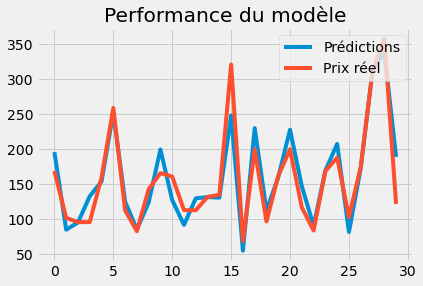

In [12]:
plt.style.use('fivethirtyeight')
plt.title('Performance du modèle')
plt.plot(list(y_pred_linear_regression)[:30])
plt.plot(list(y_test)[:30])
plt.legend(['Prédictions', 'Prix réel'], loc='upper right')

### Prédictions et fichier de soumission

In [13]:
y_pred_reg_lin = model0.predict(X_pred)
prediction = y_pred_reg_lin.flatten()

df_linear_regression = pd.DataFrame(df_pred['index'], columns=['index'])
df_linear_regression['price'] = prediction

In [14]:
df_linear_regression.to_csv("submission_linear_regression.csv", index=False)

## 3) Régression Lasso

In [5]:
train_size = 0.8
train_df, test_df, pred_df, X_train, y_train, X_test, y_test, X_pred = prepare_data(df_train, df_pred, columnsTitles, train_size)

model = Lasso()

# définir la méthode de validation croisée
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)

search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# entrainer le modèle
search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
             scoring='neg_mean_absolute_error')

In [6]:
#récupérer le meilleur alpha
best_alpha = search.best_params_['alpha']
print(best_alpha)


search.best_params_
model = Lasso(alpha=best_alpha)
model.fit(X_train, y_train)
coefs = model.coef_
print(coefs)

0.05
[ 4.93930359e-03 -4.30684161e-01 -9.56088046e-02 -4.71172237e-02
 -2.16748387e-01  9.46435613e+00  3.34323926e+00  2.58613508e+01
 -2.57704469e+01  1.53087891e+01 -1.25198711e+01 -5.98565581e+01
 -4.65996853e+00  5.03932517e-01 -3.90347671e+01 -1.43807913e-01
 -3.80198574e+00 -5.01989649e-01  3.31628839e+00 -5.80504075e-01
  2.70694132e+00 -0.00000000e+00 -4.37567483e+00  5.85177218e+00
 -0.00000000e+00 -0.00000000e+00  9.10971402e-01 -5.93687502e+00
  4.10462729e-01 -1.77130055e-01  1.63542082e+00  0.00000000e+00
 -4.17818479e-01 -0.00000000e+00  0.00000000e+00  1.57570510e+00
 -4.21458198e+00 -7.38332076e+00 -1.96721309e-01  0.00000000e+00
  6.44809701e+00 -0.00000000e+00  6.05889435e+01 -4.70227652e+01
  5.59356894e+01 -6.68226732e+01  7.96046090e+01 -2.13345572e+01
  9.91474447e+01  9.84229862e+01 -4.24242395e+01 -7.17468576e+01
 -0.00000000e+00  7.00701843e+00  5.63426969e+01  0.00000000e+00
 -2.86135869e+01  9.44641208e-01  1.26583223e+02  1.57965925e+02
 -4.62477552e+01]


#### Prédiction sur X_test et calcul de la RMSE

In [7]:
y_pred_lasso = model.predict(X_test)
print(math.sqrt(sum((y_test-y_pred_lasso)**2)/len(y_test)))

29.14401726921807


#### Visualisation de la performance 

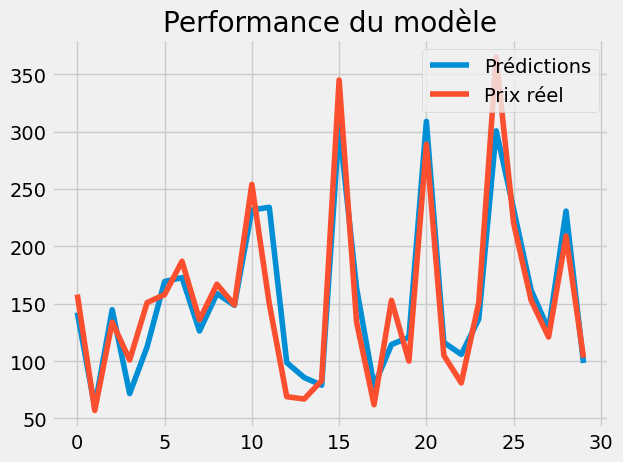

In [13]:
plt.style.use('fivethirtyeight')
plt.title('Performance du modèle')
plt.plot(list(y_pred_lasso)[:30])
plt.plot(list(y_test)[:30])
plt.legend(['Prédictions', 'Prix réel'], loc='upper right')

### Prédictions et fichier de soumission

In [14]:
y_pred_lasso = model.predict(X_pred)
prediction = y_pred_lasso.flatten()

df_lasso = pd.DataFrame(df_pred['index'], columns=['index'])
df_lasso['price'] = prediction

In [15]:
df_lasso.to_csv("submission_lasso.csv", index=False)

## 4) Régression Ridge

In [108]:
train_size = 0.8
train_df, test_df, pred_df, X_train, y_train, X_test, y_test, X_pred = prepare_data(df_train, df_pred, columnsTitles, train_size)

#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
model = RidgeCV(alphas=arange(0, 1, 0.01), cv=cv, scoring = None)

#fit model
model.fit(X_train, y_train)

RidgeCV(alphas=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1))

#### Prédiction sur X_test et calcul de la RMSE

In [109]:
y_pred_ridge = model.predict(X_test)
print(math.sqrt(sum((y_test-y_pred_ridge)**2)/len(y_test)))

29.167572791091942


#### Visualisation de la performance 

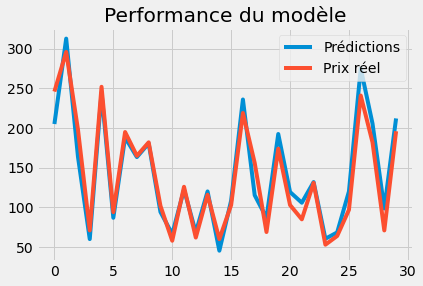

In [110]:
plt.style.use('fivethirtyeight')
plt.title('Performance du modèle')
plt.plot(list(y_pred_ridge)[:30])
plt.plot(list(y_test)[:30])
plt.legend(['Prédictions', 'Prix réel'], loc='upper right')

### Prédictions et fichier de soumission

In [111]:
y_pred_ridge = model.predict(X_pred)
prediction = y_pred_ridge.flatten()

df_ridge = pd.DataFrame(df_pred['index'], columns=['index'])
df_ridge['price'] = prediction

In [112]:
df_ridge.to_csv("submission_ridge.csv", index=False)

## 5) Réseaux de neurones

#### Une fonction pour calculer la RMSE (root-mean-square error) :

In [5]:
def val_error_rate(X_test) : 
    y_pred_reseau_neurone = model.predict(X_test)
    pred = y_pred_reseau_neurone.flatten()
    err = math.sqrt(sum((y_test-pred)**2)/len(y_test))
    return(err, y_pred_reseau_neurone)

### 5.1 Premier modèle

In [6]:
train_size = 0.8
train_df, test_df, pred_df, X_train, y_train, X_test, y_test, X_pred = prepare_data(df_train, df_pred, columnsTitles, train_size)

def model1():
    # Réseau feedforward
    model = tf.keras.Sequential() #lance un reseau ou on va pouvoir mettre des couches

    model.add(tf.keras.Input(shape=X_train.shape[1]))

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128*32, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(128*8, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(128*2, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(1))

    # Compilation du modèle
    model.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer = 'adam', metrics = ['mae']) 
    return model

# Définition / construction du modèle
model = model1()
model.summary()

#entrainer le modèle 
hist = model.fit(x=X_train, y=y_train, validation_data=(X_test,y_test),batch_size=100, epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 61)                0         
                                                                 
 dense (Dense)               (None, 4096)              253952    
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

#### Prédiction sur X_test et calcul de la RMSE

In [7]:
err, y_pred_reseau_neurone = val_error_rate(X_test)
print(err)

3827/3827 [==============================] - 47s 12ms/step
12.604862727098713


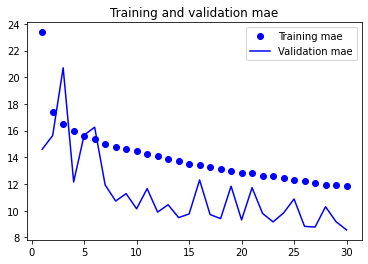

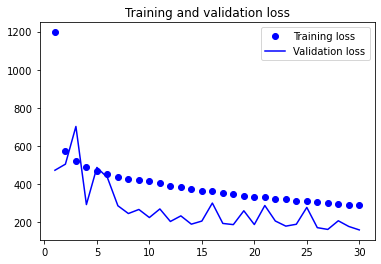

In [8]:
mae = hist.history['mae']
val_mae = hist.history['val_mae']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Visualisation de la performance 

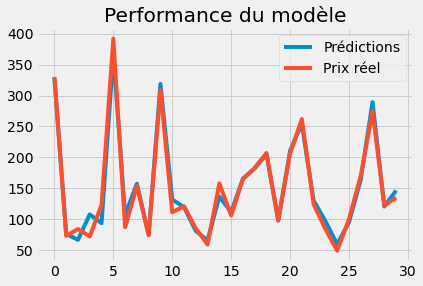

In [9]:
plt.style.use('fivethirtyeight')
plt.title('Performance du modèle')
plt.plot(list(y_pred_reseau_neurone)[:30])
plt.plot(list(y_test)[:30])
plt.legend(['Prédictions', 'Prix réel'], loc='upper right')

### Prédictions et fichier de soumission

In [9]:
y_pred_reseau_neurone = model.predict(X_pred)
prediction = y_pred_reseau_neurone.flatten()

df_rn = pd.DataFrame(df_pred['index'], columns=['index'])
df_rn['price'] = prediction

208/208 [==============================] - 2s 11ms/step


In [10]:
df_rn.to_csv("submission_neural_network1.csv", index=False)

### 5.2 Second modèle

In [5]:
train_size = 0.8
train_df, test_df, pred_df, X_train, y_train, X_test, y_test, X_pred = prepare_data(df_train, df_pred, columnsTitles, train_size)

def model2():
    # Réseau feedforward
    model = tf.keras.Sequential() #lance un reseau ou on va pouvoir mettre des couches

    model.add(tf.keras.Input(shape=X_train.shape[1]))

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128*8, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(128*4, activation = 'relu'))
    
    model.add(tf.keras.layers.Dense(128*2, activation = 'relu'))
    
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(1))

    # Compilation du modèle
    model.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer = 'adam', metrics = ['mae']) 
    return model

# Définition / construction du modèle
model = model2()
model.summary()

#entrainer le modèle 
hist2 = model.fit(x=X_train, y=y_train, validation_data=(X_test,y_test),batch_size=70, epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 61)                0         
                                                                 
 dense (Dense)               (None, 1024)              63488     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8

#### Prédiction sur X_test et calcul de la RMSE

In [7]:
err, y_pred_reseau_neurone = val_error_rate(X_test)
print(err)

3827/3827 [==============================] - 13s 3ms/step
22.15165553630983


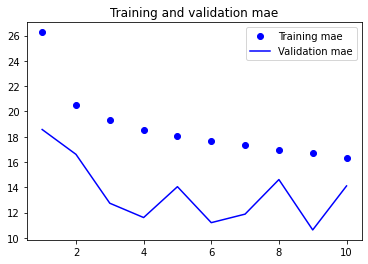

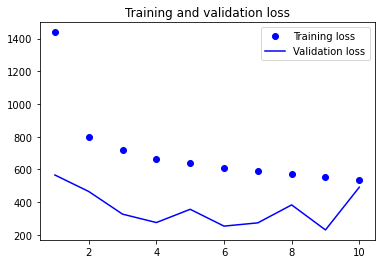

In [12]:
mae = hist2.history['mae']
val_mae = hist2.history['val_mae']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Visualisation de la performance 

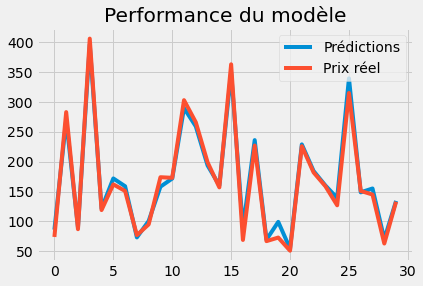

In [9]:
plt.style.use('fivethirtyeight')
plt.title('Performance du modèle')
plt.plot(list(y_pred_reseau_neurone)[:30])
plt.plot(list(y_test)[:30])
plt.legend(['Prédictions', 'Prix réel'], loc='upper right')

### Prédictions et fichier de soumission

In [10]:
y_pred_reseau_neurone = model.predict(X_pred)
prediction = y_pred_reseau_neurone.flatten()

df_rn = pd.DataFrame(df_pred['index'], columns=['index'])
df_rn['price'] = prediction

208/208 [==============================] - 1s 6ms/step


In [11]:
df_rn.to_csv("submission_neural_network2.csv", index=False)

## 6) Arbres de décision

In [67]:
train_size = 0.8
train_df, test_df, pred_df, X_train, y_train, X_test, y_test, X_pred = prepare_data(df_train, df_pred, columnsTitles, train_size)

regressor1 = DecisionTreeRegressor(random_state = 0) 

regressor1.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

#### Prédiction sur X_test et calcul de la RMSE

In [68]:
y_pred_decision_tree = regressor1.predict(X_test)
print(math.sqrt(sum((y_test-y_pred_decision_tree)**2)/len(y_test)))

2.697622815148021


Le résultat donné par la plateforme Kaggle est de 30.12 environ. Nous avons donc un gros écart entre la RMSE que nous avons calculé et celle retourné sur la plateforme. 

Cet écart peut être dû à différents facteurs comme par exemple la qualité des données avec des données de test et de prédiction différentes en termes de qualité, de complexité ou de bruit. En effet, les données de test peuvent être plus proches des données d'entraînement, ce qui facilite la généralisation des résultats. \
Un autre facteur peut être le nombre d'observations dans les jeux de données. Étant donné que le jeu de données de prédiction contient un faible nombre d'observations, il est possible que cela ait entraîné une incertitude plus élevée dans les prédictions et une augmentation de l'erreur. \
Enfin, il est possible que l'écart soit dû à la précision du modèle car celui-ci est sous-ajusté ou sur-ajusté.

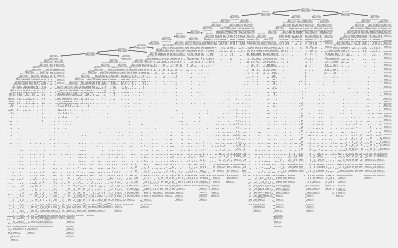

In [72]:
plot_tree(regressor1) 
plt.show()

#### Visualisation de la performance 

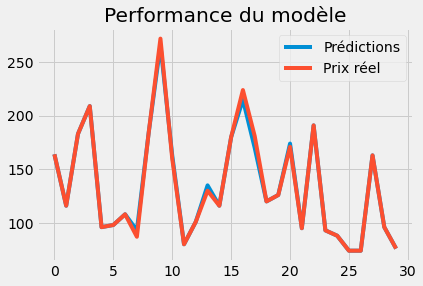

In [69]:
plt.style.use('fivethirtyeight')
plt.title('Performance du modèle')
plt.plot(list(y_pred_decision_tree)[:30])
plt.plot(list(y_test)[:30])
plt.legend(['Prédictions', 'Prix réel'], loc='upper right')

Afin d'obtenir un meilleur résultat et d'éviter les cas de sur-apprentissage et sous-apprentissage, nous ajoutons des valeurs pour les imputs min_samples_leaf et max_depth. \
On va utiliser la méthode Grid Search pour tester plusieurs combinaisons de paramètres pour optimiser notre arbre de décision.

In [73]:
parameters = {'max_depth':range(2,61),'min_samples_leaf':range(2,7)}
reg = GridSearchCV(DecisionTreeRegressor(), parameters, n_jobs=-1)
reg.fit(X=X_train, y=y_train)
tree_model = reg.best_estimator_
print (reg.best_score_, reg.best_params_) 

0.9984202237091335 {'max_depth': 58, 'min_samples_leaf': 2}


In [5]:
train_size = 0.8
train_df, test_df, pred_df, X_train, y_train, X_test, y_test, X_pred = prepare_data(df_train, df_pred, columnsTitles, train_size)

regressor2 = DecisionTreeRegressor(random_state = 0, min_samples_leaf = 2, max_depth = 58) 

regressor2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=58, min_samples_leaf=2, random_state=0)

#### Prédiction sur X_test et calcul de la RMSE

In [6]:
y_pred_decision_tree2 = regressor2.predict(X_test)
print(math.sqrt(sum((y_test-y_pred_decision_tree2)**2)/len(y_test)))

2.8863976579878243


#### Visualisation de la performance 

In [ ]:
plt.style.use('fivethirtyeight')
plt.title('Performance du modèle')
plt.plot(list(y_pred_decision_tree2)[:30])
plt.plot(list(y_test)[:30])
plt.legend(['Prédictions', 'Prix réel'], loc='upper right')

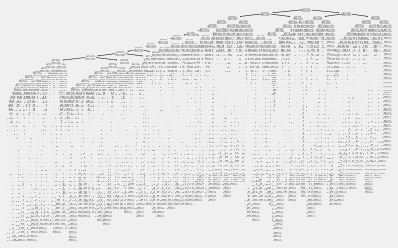

In [102]:
plot_tree(regressor2) 
plt.show()

### Prédictions et fichier de soumission

In [70]:
y_pred_arbre_decision = regressor1.predict(X_pred)
prediction = y_pred_arbre_decision.flatten()

df_dt = pd.DataFrame(df_pred['index'], columns=['index'])
df_dt['price'] = prediction

In [71]:
df_dt.to_csv("submission_decision_tree1.csv", index=False)

In [78]:
y_pred_arbre_decision2 = regressor2.predict(X_pred)
prediction2 = y_pred_arbre_decision2.flatten()

df_dt2 = pd.DataFrame(df_pred['index'], columns=['index'])
df_dt2['price'] = prediction2

In [79]:
df_dt2.to_csv("submission_decision_tree2.csv", index=False)

## 7) Forêts aléatoires 

In [ ]:
train_size = 0.8
train_df, test_df, pred_df, X_train, y_train, X_test, y_test, X_pred = prepare_data(df_train, df_pred, columnsTitles, train_size)

parameters = {'max_depth':range(58,59),'min_samples_leaf':range(2,3),'n_estimators':range(50,101)}
reg = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=-1)
reg.fit(X=X_train, y=y_train)
rf_model = reg.best_estimator_
print (reg.best_score_, reg.best_params_)

In [13]:
regressor3 = RandomForestRegressor(n_estimators = 100, 
                                  random_state = 0, 
                                 min_samples_leaf = 2, 
                                  max_depth = 58)

regressor3.fit(X_train, y_train)

RandomForestRegressor(max_depth=58, min_samples_leaf=2, random_state=0)

#### Prédiction sur X_test et calcul de la RMSE

In [14]:
y_pred_random_forest = regressor3.predict(X_test)
print(math.sqrt(sum((y_test-y_pred_random_forest)**2)/len(y_test)))

2.678776382760411


#### Visualisation de la performance 

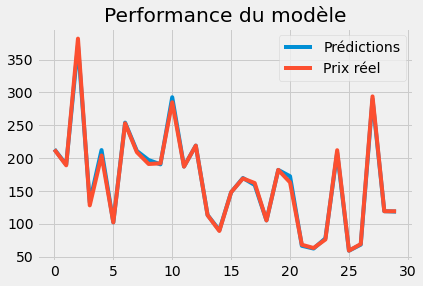

In [15]:
plt.style.use('fivethirtyeight')
plt.title('Performance du modèle')
plt.plot(list(y_pred_random_forest)[:30])
plt.plot(list(y_test)[:30])
plt.legend(['Prédictions', 'Prix réel'], loc='upper right')

Text(0.5, 0, 'Relative Importance')

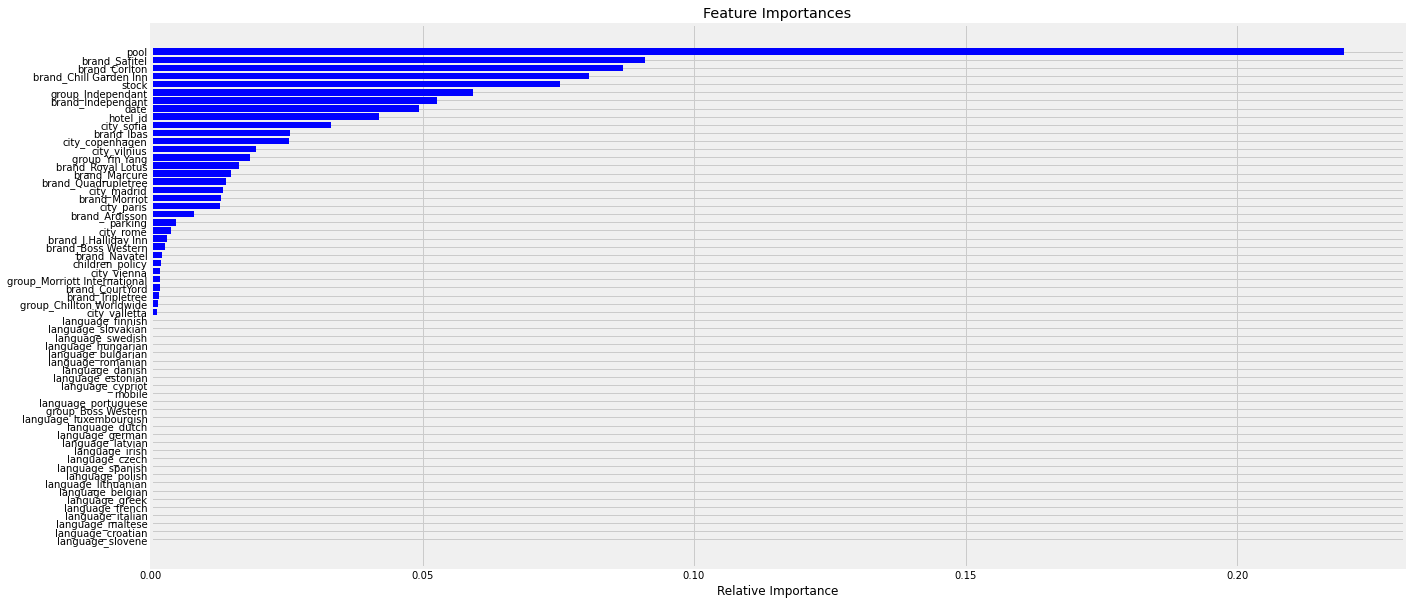

In [17]:
importances = regressor3.feature_importances_
indices = np.argsort(importances)
liste_variables = list(X_train.columns)
# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

In [18]:
pd.DataFrame(regressor3.feature_importances_,
              index = X_train.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

,importance
pool,0.219690
brand_Safitel,0.090906
brand_Corlton,0.086904
brand_Chill Garden Inn,0.080682
stock,0.075326
...,...
language_french,0.000032
language_italian,0.000028
language_maltese,0.000025
language_croatian,0.000024


### Prédictions et fichier de soumission

In [85]:
y_pred_foret_aleatoire = regressor3.predict(X_pred)
prediction = y_pred_foret_aleatoire.flatten()

df_rf = pd.DataFrame(df_pred['index'], columns=['index'])
df_rf['price'] = prediction

In [86]:
df_rf.to_csv("submission_random_forest.csv", index=False)